In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import polars as pl
import seaborn as sns
import shap

from biobank_olink.constants import PROJECT_DATA

nb_data = PROJECT_DATA / "olink"

sns.set()

In [2]:
# from tqdm import tqdm
# import numpy as np

# olink_xlsx = nb_data / "Olink population_ASI_only.xlsx"
# sheet_names = pd.ExcelFile(olink_xlsx).sheet_names
# 
# chunk_num = 4
# for i, sheet_split in tqdm(enumerate(np.array_split(sheet_names, chunk_num)), total=chunk_num):
#     dfs = pl.read_excel(olink_xlsx, sheet_name=list(sheet_split),
#                         infer_schema_length=1_000_000)
#     pl.concat(dfs.values()).write_parquet(nb_data / f"olink_population_ASI_only_{i}.parquet")
#     del dfs
# 

In [3]:
index_cols = ["sex", "age", "BMI", "Smokinstatus", "HTNgroup", "ASI"]
cols = ["protein_id", "result"] + index_cols

coding = pl.read_csv(nb_data / "coding143.tsv", separator="\t").with_columns(
    pl.col("meaning").str.split(";").list.get(0).alias("meaning"),
)
df = (
    pl.scan_parquet(nb_data / "olink_population_ASI_only_*.parquet")
    .select(cols)
    .filter(pl.col("ASI").is_not_null(), pl.col("HTNgroup") != 2)
    .with_columns(
        pl.col("protein_id").replace_strict(
            coding["coding"], coding["meaning"], return_dtype=pl.String
        )
    )
).collect()

df = df.pivot(on="protein_id", index=index_cols, values="result")
df = df.with_columns(
    df["Smokinstatus"].to_dummies(drop_first=True)
).drop("Smokinstatus").filter(
    pl.col("ASI") < 25
)
len(df)

9532

In [4]:
df_htn = df.filter(pl.col("HTNgroup") == 1).select(pl.exclude("HTNgroup")).to_pandas()
df_ntn = df.filter(pl.col("HTNgroup") == 0).select(pl.exclude("HTNgroup")).to_pandas()
df_all = df.to_pandas()

"all: {}, htn: {}, ntn: {}".format(df_all.shape, df_htn.shape, df_ntn.shape)

'all: (9532, 2931), htn: (3912, 2930), ntn: (5620, 2930)'

In [7]:
import wandb

import numpy as np
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split


def shap_to_importance(values, feat_names):
    return pd.Series(np.abs(values.values).sum(axis=0), index=feat_names).sort_values(
        ascending=False)


def train_xgb(x, y, config):
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=42)
    estimator: XGBRegressor = XGBRegressor(
        tree_method="hist", random_state=42,
        early_stopping_rounds=10,
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        learning_rate=config["learning_rate"],
        subsample=config["subsample"],
        colsample_bytree=config["colsample_bytree"],
        gamma=config["gamma"],
        min_child_weight=config["min_child_weight"],
        reg_alpha=config["reg_alpha"],
        reg_lambda=config["reg_lambda"],
        device="gpu",
    )

    estimator.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_eval, y_eval)], verbose=5)
    print(f"Train R2: {estimator.score(X_train, y_train):.4f}",
          f"Eval R2: {estimator.score(X_eval, y_eval):.4f}")

    ax = sns.scatterplot(x=y_train, y=estimator.predict(X_train), alpha=0.5)
    ax.set(xlabel="True", ylabel="Predict")
    return estimator


def get_elbow_point(series: pd.Series):
    from kneed import KneeLocator

    x = np.arange(0, len(series))
    y = series.values
    kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow

    ax = series.plot.line()
    ax.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    return elbow_point



## XGBoost

### ALL

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:3.01833	validation_1-rmse:2.90681
[5]	validation_0-rmse:2.94804	validation_1-rmse:2.84047
[10]	validation_0-rmse:2.89826	validation_1-rmse:2.79232
[15]	validation_0-rmse:2.86449	validation_1-rmse:2.76480
[20]	validation_0-rmse:2.84149	validation_1-rmse:2.74818
[25]	validation_0-rmse:2.82212	validation_1-rmse:2.73162
[30]	validation_0-rmse:2.80621	validation_1-rmse:2.71887
[35]	validation_0-rmse:2.79329	validation_1-rmse:2.71687
[40]	validation_0-rmse:2.78276	validation_1-rmse:2.71082
[45]	validation_0-rmse:2.77122	validation_1-rmse:2.70713
[50]	validation_0-rmse:2.76062	validation_1-rmse:2.70562
[55]	validation_0-rmse:2.75134	validation_1-rmse:2.70264
[60]	validation_0-rmse:2.74256	validation_1-rmse:2.70240
[65]	validation_0-rmse:2.73448	validation_1-rmse:2.70196
[70]	validation_0-rmse:2.72734	validation_1-rmse:2.69988
[75]	validation_0-rmse:2.71995	validation_1-rmse:2.69646
[80]	validation_0-rmse:2.71265	validation_1-rmse:2.69523
[85]	validation_0-rmse:2.70479	va

/home/local/PARTNERS/pr712/miniconda3/envs/olink/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:32:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Train R2: 0.2191 Eval R2: 0.1562


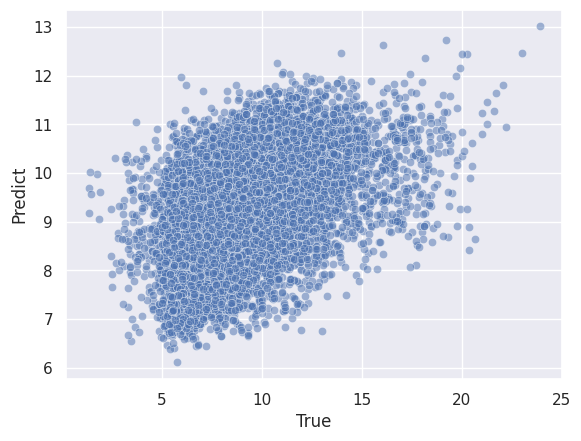

In [8]:
x_all, y_all = df_all.drop("ASI", axis=1), df_all["ASI"]
all_sweep = wandb.Api().sweep("olink_asi_all/9wica2px")
best_run = all_sweep.best_run(order="r2")
model_all = train_xgb(x_all, y_all, best_run.config)

np.float64(0.3971254210066906)

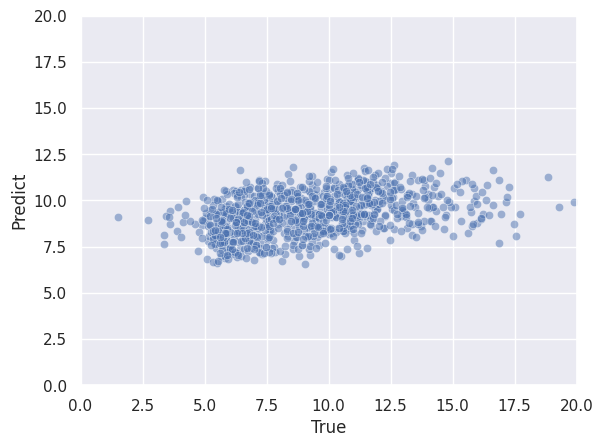

In [9]:
X_train, X_eval, y_train, y_eval = train_test_split(x_all, y_all, test_size=0.1, random_state=42)
ax = sns.scatterplot(x=y_eval, y=model_all.predict(X_eval), alpha=0.5)
ax.set(xlabel="True", ylabel="Predict", ylim=(0, 20), xlim=(0, 20))

#compute correlation
np.corrcoef(y_eval, model_all.predict(X_eval))[1, 0]


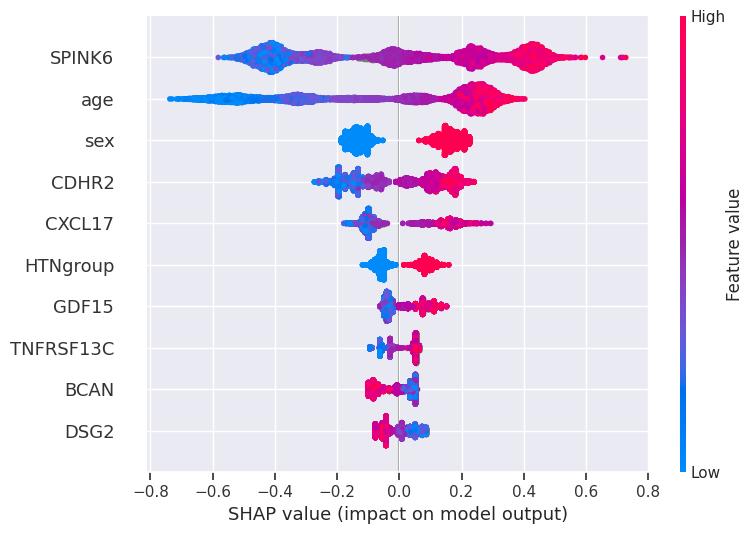

In [10]:
explainer = shap.TreeExplainer(model_all)
shap_values_all = explainer(x_all)
shap.summary_plot(shap_values_all, x_all, max_display=10)

54

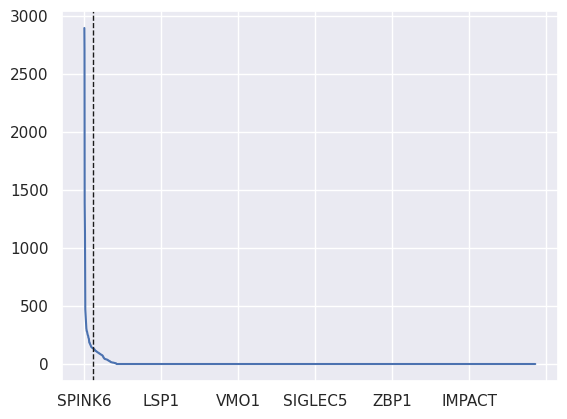

In [11]:
imps = shap_to_importance(shap_values_all, x_all.columns)
all_elbow = get_elbow_point(imps)
all_important_feats = imps[:all_elbow]
len(all_important_feats)

In [12]:
all_important_feats.index

Index(['SPINK6', 'age', 'sex', 'CDHR2', 'CXCL17', 'HTNgroup', 'GDF15',
       'TNFRSF13C', 'BCAN', 'DSG2', 'GUSB', 'TCL1A', 'MLN', 'IGSF9', 'PLAT',
       'SEZ6L2', 'NPL', 'ACP5', 'CDCP1', 'TNR', 'ACY1', 'KEL', 'VWC2L', 'PAEP',
       'GFRA3', 'SSC4D', 'HGF', 'GCLM', 'LIPF', 'SHISA5', 'PON3', 'CLSPN',
       'OPTC', 'PRAP1', 'GSTA3', 'CELSR2', 'CTSD', 'IGFBP1', 'NOS3', 'EDDM3B',
       'IFNLR1', 'BCHE', 'FURIN', 'TACSTD2', 'CPM', 'HMOX1', 'NTF3', 'HAVCR1',
       'BCL2L11', 'APCS', 'BOC', 'PRSS8', 'AHSP', 'MSLN'],
      dtype='object')

### NTN

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:2.79302	validation_1-rmse:2.64909
[5]	validation_0-rmse:2.71955	validation_1-rmse:2.62352
[10]	validation_0-rmse:2.64957	validation_1-rmse:2.59755
[15]	validation_0-rmse:2.58115	validation_1-rmse:2.58063
[20]	validation_0-rmse:2.52023	validation_1-rmse:2.56394
[25]	validation_0-rmse:2.45984	validation_1-rmse:2.54826
[30]	validation_0-rmse:2.40264	validation_1-rmse:2.53696
[35]	validation_0-rmse:2.34567	validation_1-rmse:2.53069
[40]	validation_0-rmse:2.29584	validation_1-rmse:2.52212
[45]	validation_0-rmse:2.24847	validation_1-rmse:2.51529
[50]	validation_0-rmse:2.20332	validation_1-rmse:2.50665
[55]	validation_0-rmse:2.15943	validation_1-rmse:2.50005
[60]	validation_0-rmse:2.11778	validation_1-rmse:2.49443
[65]	validation_0-rmse:2.07502	validation_1-rmse:2.48667
[70]	validation_0-rmse:2.03778	validation_1-rmse:2.48239
[75]	validation_0-rmse:1.99977	validation_1-rmse:2.47954
[80]	validation_0-rmse:1.96404	validation_1-rmse:2.47694
[85]	validation_0-rmse:1.93168	va

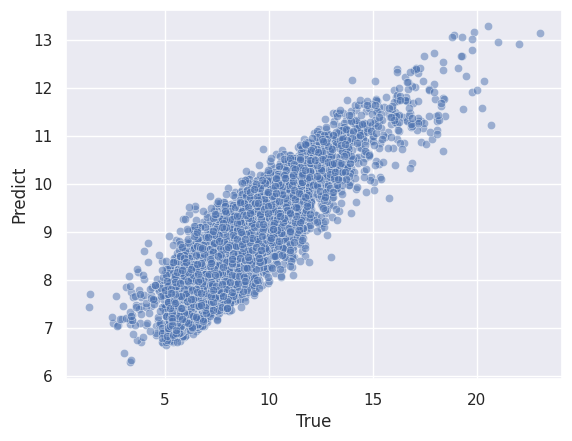

In [13]:
x_ntn, y_ntn = df_ntn.drop("ASI", axis=1), df_ntn["ASI"]

htn_sweep = wandb.Api().sweep("olink_asi_ntn/sh6dtmsj")
best_run = htn_sweep.best_run(order="r2")
model_ntn = train_xgb(x_ntn, y_ntn, best_run.config)

np.float64(0.37566073294552554)

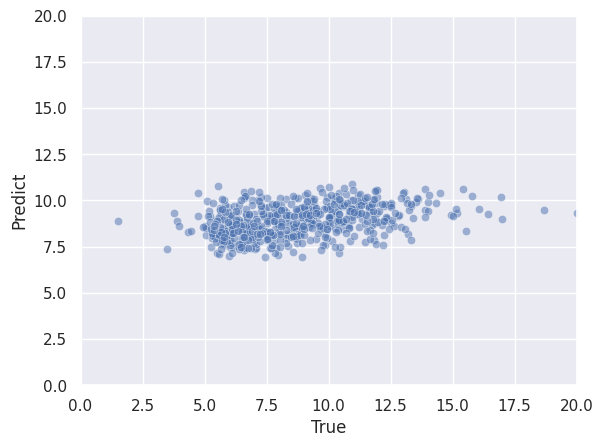

In [14]:
X_train, X_eval, y_train, y_eval = train_test_split(x_ntn, y_ntn, test_size=0.1, random_state=42)
ax = sns.scatterplot(x=y_eval, y=model_ntn.predict(X_eval), alpha=0.5)
ax.set(xlabel="True", ylabel="Predict", ylim=(0, 20), xlim=(0, 20))

#compute correlation
np.corrcoef(y_eval, model_ntn.predict(X_eval))[1, 0]


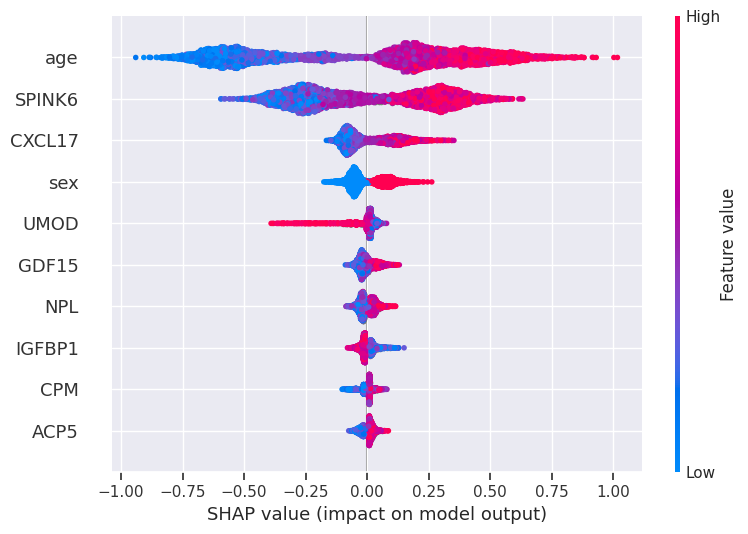

In [15]:
explainer = shap.TreeExplainer(model_ntn)
shap_values_ntn = explainer(x_ntn)
shap.summary_plot(shap_values_ntn, x_ntn, max_display=10)

19

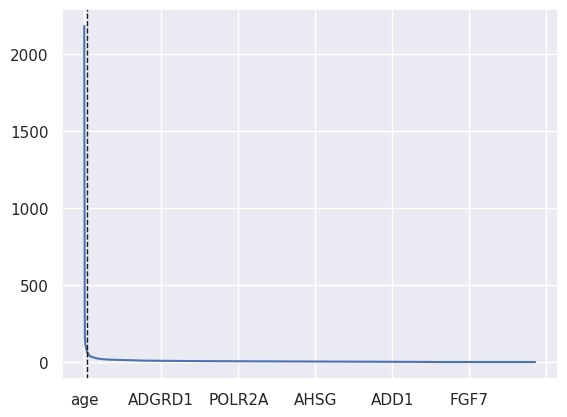

In [16]:
imps = shap_to_importance(shap_values_ntn, x_ntn.columns)
ntn_elbow = get_elbow_point(imps)
ntn_important_feats = imps[:ntn_elbow]
len(ntn_important_feats)

In [17]:
ntn_important_feats.index

Index(['age', 'SPINK6', 'CXCL17', 'sex', 'UMOD', 'GDF15', 'NPL', 'IGFBP1',
       'CPM', 'ACP5', 'PRCP', 'SSC5D', 'CDHR2', 'CA12', 'ADGRG2', 'SEZ6L2',
       'PLAT', 'NCAN', 'CALCA'],
      dtype='object')

In [19]:
matteos_ntn_feats = set(
    pl.scan_csv(nb_data / "GLM Olink ASI ntn ZscoreAll.csv", skip_rows=1)
    .filter(pl.col("Sig.-adj FDR") <= 0.05)
    .select(pl.col("protein_name").str.split(";").list.first().alias("protein_name"))
    .collect()
    ["protein_name"]
    .to_list()
)

same_feats_ntn = (matteos_ntn_feats & set(ntn_important_feats.index))
same_feats_ntn, len(same_feats_ntn)

({'ACP5',
  'ADGRG2',
  'CDHR2',
  'CPM',
  'CXCL17',
  'GDF15',
  'IGFBP1',
  'NPL',
  'PLAT',
  'PRCP',
  'SPINK6',
  'SSC5D',
  'UMOD'},
 13)

### htn

wandb: Sorting runs by -summary_metrics.r2


[0]	validation_0-rmse:3.23936	validation_1-rmse:3.14475
[5]	validation_0-rmse:3.05666	validation_1-rmse:3.10115
[10]	validation_0-rmse:2.89698	validation_1-rmse:3.06557
[15]	validation_0-rmse:2.76315	validation_1-rmse:3.04415
[20]	validation_0-rmse:2.63640	validation_1-rmse:3.02259
[25]	validation_0-rmse:2.53313	validation_1-rmse:3.01003
[30]	validation_0-rmse:2.43046	validation_1-rmse:3.00950
[35]	validation_0-rmse:2.34032	validation_1-rmse:3.00151
[40]	validation_0-rmse:2.24651	validation_1-rmse:2.99276
[45]	validation_0-rmse:2.17739	validation_1-rmse:2.98511
[50]	validation_0-rmse:2.10782	validation_1-rmse:2.99074
[55]	validation_0-rmse:2.04401	validation_1-rmse:2.98744
[60]	validation_0-rmse:1.97778	validation_1-rmse:2.97853
[65]	validation_0-rmse:1.91138	validation_1-rmse:2.97667
[70]	validation_0-rmse:1.85086	validation_1-rmse:2.97870
[74]	validation_0-rmse:1.80053	validation_1-rmse:2.97931
Train R2: 0.6591 Eval R2: 0.1020


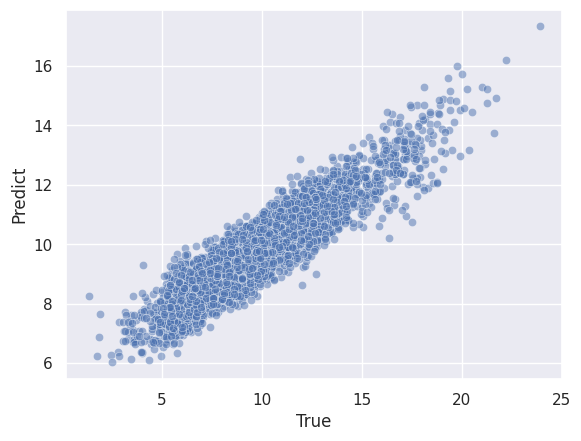

In [20]:
htn_sweep = wandb.Api().sweep("olink_asi_htn/mehz3cf5")
best_run = htn_sweep.best_run(order="r2")

x_htn, y_htn = df_htn.drop("ASI", axis=1), df_htn["ASI"]
model_htn = train_xgb(x_htn, y_htn, best_run.config)

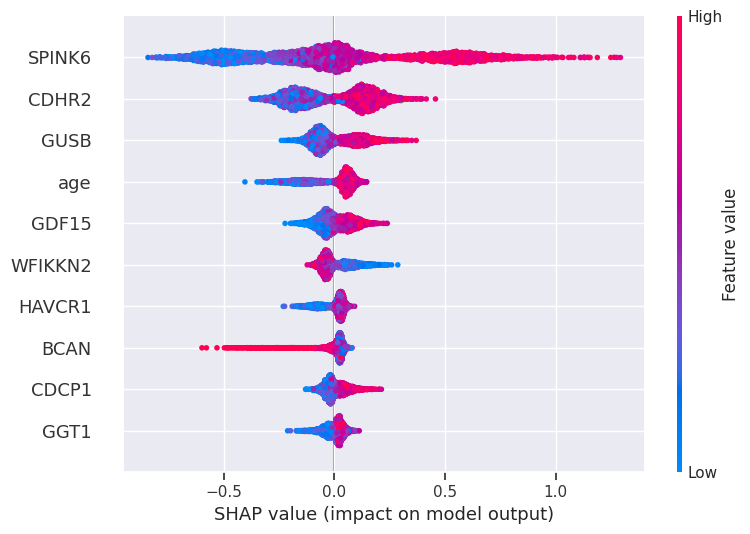

In [21]:
explainer = shap.TreeExplainer(model_htn)
shap_values_htn = explainer(x_htn)
shap.summary_plot(shap_values_htn, x_htn, max_display=10)

31

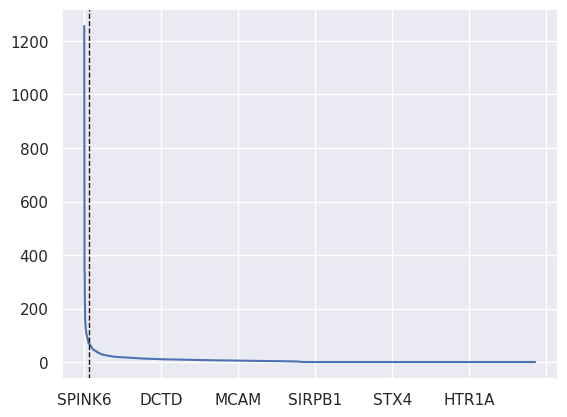

In [22]:
imps = shap_to_importance(shap_values_htn, x_htn.columns)
htn_elbow = get_elbow_point(imps)
htn_important_feats = imps[:htn_elbow]
len(htn_important_feats)

In [23]:
htn_important_feats.index

Index(['SPINK6', 'CDHR2', 'GUSB', 'age', 'GDF15', 'WFIKKN2', 'HAVCR1', 'BCAN',
       'CDCP1', 'GGT1', 'PTP4A3', 'MLN', 'HGF', 'sex', 'ARSB', 'DCXR',
       'SPINK5', 'KITLG', 'TNFRSF13C', 'CTSZ', 'CXCL14', 'VTI1A', 'KEL',
       'OPTC', 'CHI3L1', 'TCL1A', 'IL1RN', 'CXCL17', 'SFRP1', 'PON3', 'PGA4'],
      dtype='object')

In [24]:
matteos_feats_htn = set(
    pl.scan_csv(nb_data / "GLM Olink ASI htn ZscoreAll.csv", skip_rows=1)
    .filter(pl.col("Sig.-adj FDR") <= 0.05)
    .select(pl.col("ptotein_name").str.split(";").list.first().alias("protein_name"))
    .collect()
    ["protein_name"]
    .to_list()
)

same_feats_htn = (matteos_feats_htn & set(htn_important_feats.index))
same_feats_htn, len(same_feats_htn)

({'ARSB',
  'BCAN',
  'CDCP1',
  'CDHR2',
  'CTSZ',
  'CXCL17',
  'DCXR',
  'GDF15',
  'GGT1',
  'GUSB',
  'HAVCR1',
  'HGF',
  'IL1RN',
  'KEL',
  'KITLG',
  'OPTC',
  'PON3',
  'PTP4A3',
  'SPINK6',
  'TCL1A',
  'TNFRSF13C',
  'WFIKKN2'},
 22)

## Wandb sweep

In [ ]:
from functools import partial
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import wandb


def eval_xgb(config, x, y):
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=42)

    estimator = XGBRegressor(
        colsample_bytree=config.colsample_bytree,
        gamma=config.gamma,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        min_child_weight=config.min_child_weight,
        n_estimators=config.n_estimators,
        reg_alpha=config.reg_alpha,
        reg_lambda=config.reg_lambda,
        subsample=config.subsample,
        tree_method="hist",
        device="gpu",
        random_state=42,
        early_stopping_rounds=10,
    )

    estimator.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    return estimator.score(X_eval, y_eval)


x_htn, y_htn = df_htn.drop("ASI", axis=1), df_htn["ASI"]
objective = partial(eval_xgb, x=x_htn, y=y_htn)


def main():
    wandb.init(project="olink_asi_htn")
    score = objective(wandb.config)
    wandb.log({"r2": score})


sweep_configurations = {
    "method": "bayes",
    "metric": {"name": "r2", "goal": "maximize"},
    "parameters": {
        'n_estimators': {'distribution': 'int_uniform', 'min': 50, 'max': 500},
        'max_depth': {'distribution': 'int_uniform', 'min': 1, 'max': 10},
        'learning_rate': {'distribution': 'log_uniform', 'min': 0.001, 'max': 0.1},
        'subsample': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'gamma': {'distribution': 'uniform', 'min': 0, 'max': 10},
        'min_child_weight': {'distribution': 'int_uniform', 'min': 1, 'max': 20},
        'reg_alpha': {'distribution': 'log_uniform', 'min': 1e-5, 'max': 100},
        'reg_lambda': {'distribution': 'log_uniform', 'min': 1e-5, 'max': 100}
    },
}

sweep_id = wandb.sweep(sweep_configurations, project="olink_asi_htn")
sweep_id

In [ ]:
wandb.agent(sweep_id, function=main)